# Модель DeepLabV3

In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import albumentations as A
import numpy as np
from pathlib import Path
from PIL import Image
import os
from typing import Dict, Any
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from typing import Dict, Any
import torchmetrics
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.images = sorted(list(self.image_dir.glob("*.png"))) 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.mask_dir / img_path.name  # Маска с таким же именем

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))  # Маска в градациях серого
        mask = (mask > 0).astype(np.float32)  # Бинарная маска (0 или 1)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
        
        if len(mask.shape) == 2:  # If mask is (256, 256), add channel dimension
            mask = mask[None, ...]  # Shape: (1, 256, 256)

        return image, mask

# Аугментация
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

In [ ]:
train_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\train\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\train\masks',
    transform=train_transform
)

valid_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\val\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\val\masks',
    transform=val_transform
)

test_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\test\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\test\masks',
    transform=val_transform
)

train_loader = DataLoader(train_dataset,
                                batch_size=4,
                                shuffle=True
                                )
valid_loader = DataLoader(valid_dataset,
                                batch_size=4
                                )
test_loader = DataLoader(test_dataset,
                                batch_size=4
                                )

images, masks = next(iter(train_loader))
print("Размерность изображений:", images.shape)
print("Размерность масок:", masks.shape)
print("Тип изображений:", images.dtype)
print("Тип масок:", masks.dtype)
print("Классы:", masks.unique())

Размерность изображений: torch.Size([4, 3, 256, 256])
Размерность масок: torch.Size([4, 1, 256, 256])
Тип изображений: torch.float32
Тип масок: torch.float32
Классы: tensor([0., 1.])


In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchmetrics
from typing import Dict, Any


class DeepLabV3PlusLightning(pl.LightningModule):
    def __init__(self, encoder_name="resnet50", learning_rate=1e-3, encoder_weights='imagenet'):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=1,
            activation=None,
        )
        self.criterion = nn.BCEWithLogitsLoss()  # Лосс для бинарной сегментации
        self.lr = learning_rate
        
        # Инициализация метрик
        self.train_iou = torchmetrics.JaccardIndex(task="binary", num_classes=2)
        self.val_iou = torchmetrics.JaccardIndex(task="binary", num_classes=2)
        self.test_iou = torchmetrics.JaccardIndex(task="binary", num_classes=2)
        
        self.train_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.val_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.test_accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
        
        self.train_precision = torchmetrics.Precision(task="binary", num_classes=2)
        self.val_precision = torchmetrics.Precision(task="binary", num_classes=2)
        self.test_precision = torchmetrics.Precision(task="binary", num_classes=2)
        
        self.train_recall = torchmetrics.Recall(task="binary", num_classes=2)
        self.val_recall = torchmetrics.Recall(task="binary", num_classes=2)
        self.test_recall = torchmetrics.Recall(task="binary", num_classes=2)
        
        self.train_f1 = torchmetrics.F1Score(task="binary", num_classes=2)
        self.val_f1 = torchmetrics.F1Score(task="binary", num_classes=2)
        self.test_f1 = torchmetrics.F1Score(task="binary", num_classes=2)

    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch, stage):
        images, masks = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.float())
        
        # Применяем сигмоиду и порог для получения бинарных предсказаний
        preds = torch.sigmoid(outputs) > 0.5
        
        metrics = {
            f"{stage}_loss": loss,
            f"{stage}_iou": getattr(self, f"{stage}_iou")(preds, masks.float()),
            f"{stage}_accuracy": getattr(self, f"{stage}_accuracy")(preds, masks.float()),
            f"{stage}_precision": getattr(self, f"{stage}_precision")(preds, masks.float()),
            f"{stage}_recall": getattr(self, f"{stage}_recall")(preds, masks.float()),
            f"{stage}_f1": getattr(self, f"{stage}_f1")(preds, masks.float()),
        }
        
        # Логируем метрики
        self.log_dict(metrics, prog_bar=True if stage == "val" else False)
        
        return loss if stage != "test" else metrics

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, "test")
    
    def on_train_epoch_end(self):
        # Сбрасываем метрики в конце эпохи
        self.train_iou.reset()
        self.train_accuracy.reset()
        self.train_precision.reset()
        self.train_recall.reset()
        self.train_f1.reset()
    
    def on_validation_epoch_end(self):
        # Сбрасываем метрики в конце эпохи
        self.val_iou.reset()
        self.val_accuracy.reset()
        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1.reset()
    
    def on_test_epoch_end(self):
        # Сбрасываем метрики в конце эпохи
        self.test_iou.reset()
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()

    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            patience=3, 
            factor=0.5,
            verbose=True, # type: ignore
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            }
        }

In [ ]:
# Инициализация модели
model = DeepLabV3PlusLightning(encoder_name="resnet50", learning_rate=1e-3)


# Настройка логгера TensorBoard
logger = TensorBoardLogger(save_dir="../logs/", name="DeepLab_segmentation")

# Настройка callback для сохранения лучшей модели
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  
    dirpath="../data/checkpoints/", 
    filename="deeplab-{epoch:02d}-{val_loss:.2f}",  
    save_top_k=1,
    save_last=True, 
    mode="min"  
)

# Инициализация тренера
trainer = pl.Trainer(
    max_epochs=60,  # Количество эпох
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Использовать GPU, если доступно
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10,
)

# Дообучение модели

checkpoint_path = "../data/checkpoints/deeplab-epoch=38-val_loss=0.19.ckpt"

trainer.fit(model, train_loader, valid_loader, ckpt_path=checkpoint_path)




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\URFU\VKR\Ind_pract\dissert\data\checkpoints exists and is not empty.
Restoring states from the checkpoint path at ../data/checkpoints/deeplab-epoch=38-val_loss=0.19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

   | Name            | Type               | Params | Mode 
----------------------------------------------------------------
0  | model           | DeepLabV3Plus      | 26.7 M | train
1  | criterion       | BCEWithLogitsLoss  | 0      | train
2  | train_iou       | BinaryJaccardIndex | 0      | train
3  | val_iou         | BinaryJaccard

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s]

c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 59: 100%|██████████| 1088/1088 [02:40<00:00,  6.79it/s, v_num=17, val_loss=0.198, val_iou=0.459, val_accuracy=0.928, val_precision=0.691, val_recall=0.573, val_f1=0.604]

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 1088/1088 [02:41<00:00,  6.73it/s, v_num=17, val_loss=0.198, val_iou=0.459, val_accuracy=0.928, val_precision=0.691, val_recall=0.573, val_f1=0.604]


In [ ]:
# Тестирование модели
trainer.test(model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 234/234 [00:13<00:00, 17.31it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9233434200286865     │
│          test_f1          │    0.6085978746414185     │
│         test_iou          │    0.46161898970603943    │
│         test_loss         │    0.22596703469753265    │
│      test_precision       │    0.7162193059921265     │
│        test_recall        │    0.5733767747879028     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22596703469753265,
  'test_iou': 0.46161898970603943,
  'test_accuracy': 0.9233434200286865,
  'test_precision': 0.7162193059921265,
  'test_recall': 0.5733767747879028,
  'test_f1': 0.6085978746414185}]

# Инференс

In [ ]:
# Загрузка модели из чекпоинта
 
model.eval()

DeepLabV3PlusLightning(
  (model): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]
Saved mask: ../output/deeplab\83-5-066-496_009_011_mask.png


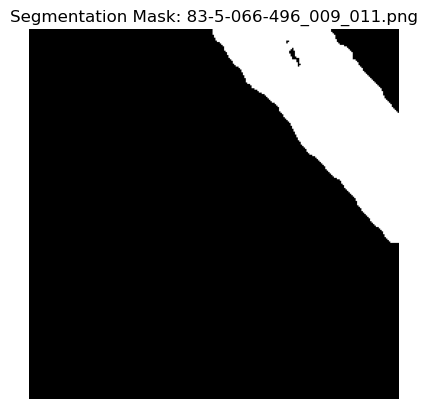

Saved mask: ../output/deeplab\83-5-066-496_038_023_mask.png


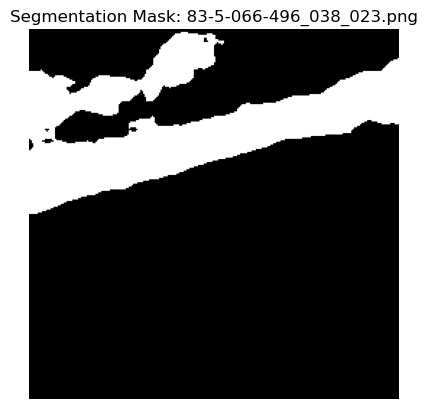

In [ ]:
import glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

input_path = r"D:\URFU\VKR\Ind_pract\dissert\input"
files = glob.glob(os.path.join(input_path, "*"))
files = [file for file in files if os.path.isfile(file)]

class InferenceDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths  # Store paths here
        self.transform = transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        return image 

# Загрузчик данных
test_dataset = InferenceDataset(files)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
image_paths = test_dataset.image_paths 

# Инференс
predictions = trainer.predict(model, dataloaders=test_loader)

# Выгрузка
output_dir = "../output/deeplab"
os.makedirs(output_dir, exist_ok=True)

# Обработка файлов 
for i, pred_batch in enumerate(predictions): # type: ignore
    
    pred = pred_batch[0]
    
    # Преобразование в маску
    prob = torch.sigmoid(pred)
    mask = (prob > 0.5).float().squeeze().cpu().numpy() 
    
    # Формирование путей выгрузки 
    path = image_paths[i]
    base_name = os.path.splitext(os.path.basename(path))[0]
    output_path = os.path.join(output_dir, f"{base_name}_mask.png")
    
    # Сохранение
    Image.fromarray((mask * 255).astype(np.uint8)).save(output_path)
    print(f"Saved mask: {output_path}")

    plt.imshow(mask, cmap="gray")
    plt.title(f"Segmentation Mask: {os.path.basename(path)}")
    plt.axis("off")
    plt.show()

In [ ]:
import glob
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, jaccard_score

# ---------- Параметры ----------
INPUT_PATH = r"..\input"
GROUND_TRUTH_DIR = r"..\truth"
OUTPUT_DIR = "../output/deeplab"
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 1   # Сделайте >1 если в pred_batch несколько масок
MASK_THRESHOLD = 0.5
MASK_BIN_THRESHOLD = 127  # Порог бинаризации GT масок

# ---------- Dataset ----------
class InferenceDataset(Dataset):
    def __init__(self, image_paths, image_size):
        self.image_paths = image_paths
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        return image

# ---------- Подготовка путей ----------
def get_image_files(input_path):
    files = glob.glob(os.path.join(input_path, "*"))
    return [file for file in files if os.path.isfile(file)]

files = get_image_files(INPUT_PATH)
test_dataset = InferenceDataset(files, IMAGE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
image_paths = test_dataset.image_paths
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --  mask_bin = mask.astype(np.uint8)

    # Расчёт метрик
    acc = accuracy_score(gt_mask.flatten(), mask_bin.flatten())
    iou = jaccard_score(gt_mask.flatten(), mask_bin.flatten(), average='binary')

    # Визуализация, если надо
    if visualize:
        plt.subplot(1,2,1)
        plt.imshow(mask, cmap="gray")
        plt.title("Predict")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(gt_mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        plt.suptitle(f"{os.path.basename(output_path)}\nAcc={acc:.3f}, IoU={iou:.3f}")
        plt.show()

    return acc, iou

# ---------- Инференс и оценка ----------
def inference_and_evaluate(trainer, model, test_loader, image_paths, gt_dir, output_dir, visualize=True):
    accuracies, ious = [], []
    predictions = trainer.predict(model, dataloaders=test_loader)
    for i, pred_batch in enumerate(predictions): # pred_batch shape: [1, 1, H, W] or [1, C, H, W]
        mask_pred = pred_batch[0]
        input_path = image_paths[i]
        base_name = os.path.splitext(os.path.basename(input_path))[0]
        output_path = os.path.join(output_dir, f"{base_name}_mask.png")
        gt_mask_path = os.path.join(gt_dir, f"{base_name}.png")
        if not os.path.exists(gt_mask_path):
            print(f"Ground truth mask not found: {gt_mask_path}, skipping")
            continue
        acc, iou = process_and_evaluate(mask_pred, gt_mask_path, output_path, visualize=visualize)
        accuracies.append(acc)
        ious.append(iou)
        print(f"{base_name}: Accuracy={acc:.4f}, IoU={iou:.4f}")
    print(f"\nСредняя Accuracy: {np.mean(accuracies):.4f}")
    print(f"Средний IoU: {np.mean(ious):.4f}")
    return accuracies, ious

# ------------------------- ЗАПУСК -------------------------
# Предполагается, что trainer, model определены!!!
# Например:
# trainer = ...
# model = ...
inference_and_evaluate(
    trainer=trainer,
    model=model,
    test_loader=test_loader,
    image_paths=image_paths,
    gt_dir=GROUND_TRUTH_DIR,
    output_dir=OUTPUT_DIR,
    visualize=True   # Включить/выключить визуализацию примеров
)-------- Функция обработки одного предсказания ----------
def process_and_evaluate(mask_pred, gt_mask_path, output_path, visualize=False):
    # Преобразуем mask_pred к (H, W)
    prob = torch.sigmoid(mask_pred)
    mask = (prob > MASK_THRESHOLD).float().squeeze().cpu().numpy()

    # Сохраняем
    Image.fromarray((mask * 255).astype(np.uint8)).save(output_path)

    # Загружаем GT маску и приводим к нужному формату
    gt_mask = Image.open(gt_mask_path).convert("L").resize(IMAGE_SIZE)
    gt_mask = np.array(gt_mask)
    gt_mask = (gt_mask > MASK_BIN_THRESHOLD).astype(np.uint8)  # бинаризация

    # Приведение к uint8 типа
  